In [3]:
from astropy.table import Table
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle
import fact.io as fio
from irf import irf_from_table, EffectiveArea, EnergyDispersion
from regions import CircleSkyRegion
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)



/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [27]:
class PowerLawSpectrum(): 
    
    def __init__(self, index, flux):
        self.index = index
        try:
            self.flux = flux.to(1/(u.TeV * u.m**2 *u.h)).value
        except AttributeError:
            self.flux = flux
            
    @classmethod
    def from_mc_production(cls, production_index, assumed_t_obs, total_showers_simulated, scatter_area, e_min, e_max):
        if e_min > e_max:
            raise ValueError('You\'re stupid')
        n = (1 / (production_index + 1)) * (e_max**(production_index + 1) - e_min**(production_index + 1))
        flux = total_showers_simulated / (assumed_t_obs * scatter_area * n)
        return PowerLawSpectrum(production_index, flux)
    
    def __repr__(self):
        return f'PowerLaw Speltrum \n Index:{self.index} \n Flux:{self.flux}'


    def draw_samples(self, e_min, e_max, t_obs, area):
        N = self.counts_in_range(e_min, e_max, t_obs, area)
        a = e_min**(self.index + 1)
        b = e_max**(self.index + 1)
        r = np.random.uniform(0, 1, int(N))
        k = (a + (b - a) * r)
        e = k**(1. / (self.index + 1))
        return e

    def counts_in_bins(self, bins, t_obs, area):
        c = np.array([self.counts_in_range(m, n, t_obs, area) for m, n in zip(bins[0:], bins[1:])])
        return c

    def counts_in_range(self, e_min, e_max, t_obs, area):
        index = self.index
        c = (1 / (index + 1)) * (e_max**(index + 1) - e_min**(index + 1))
        return c * t_obs * area * self.flux

    def event_weights(self, event_energies, e_min, e_max, production_spectrum, t_obs, area):
        gamma = -production_spectrum.index
        total_showers_simulated = production_spectrum.counts_in_range(e_min, e_max, t_obs, area)
        w = event_energies**(gamma) * (e_max**(1 - gamma) - e_min**(1 - gamma)) / (1 - gamma)
        w = w * area * t_obs / total_showers_simulated
        w = w * event_energies**self.index * self.flux
        return w   
    

In [46]:
FACT_SCATTER_AREA = (270*u.m) **2 * np.pi
T_OBS = 17.7 * u.h

N_HEGRA = (2.83e-14 / (u.GeV * u.cm**2 * u.s)).to(1/(u.TeV * u.km**2 *u.h))
INDEX_HEGRA = -2.62

N_MAGIC = ((1.5E-3)/0.001**(-2.58) / (u.TeV * u.cm**2 * u.s)).to(1/(u.TeV * u.km**2 *u.h))
INDEX_MAGIC = -2.58

FACT_MC_INDEX = -2.7

E_MIN, E_MAX = 0.2, 50

N_TOTAL = 12000000 # times sample fraction


mc_production = {'production_index': -2.0, 'assumed_t_obs':T_OBS.value, 'e_max':E_MAX, 'e_min': E_MIN, 'total_showers_simulated' : N_TOTAL, 'scatter_area' : FACT_SCATTER_AREA.value}
mc_spectrum = PowerLawSpectrum.from_mc_production(**mc_production)

print(N_MAGIC, INDEX_MAGIC)
print(N_HEGRA, INDEX_HEGRA)

982.6384636493908 1 / (h km2 TeV) -2.58
1018.8000000000001 1 / (h km2 TeV) -2.62


## Spectra

I try and forward fold some spectra here. 
Lets start by loading up some event lists.

Whats still missing:

    - Energy dispersion? Not used so far. here. 
    - Proper FACT IRF. What does it look like?
    - This interpolation business needs to be fixed properly. Need to think about edge cases.

In [47]:
dl3 = fio.read_data('../crab_dl3.hdf5', key='events')
# adapt units. CTA uses TeV everywhere. 
dl3.gamma_energy_prediction = (dl3.gamma_energy_prediction.values * u.GeV ).to('TeV').value

# make sure to use the same cut used during the generation of the IRF.
dl3_gammas = dl3.query('gamma_prediction > 0.85')

crab = SkyCoord.from_name('Crab Nebula')


# load up some montecarlo gammas
mc = fio.read_data('../../gamma_dl2_test_sample_predicted.hdf5', key='events')
mc_gammas = mc.query('gamma_prediction > 0.85')

# TODO why is this offset seemingly necessarry? 
ra = (dl3_gammas.ra_prediction.values + 0.005) * u.hourangle
dec = dl3_gammas.dec_prediction.values * u.deg - 0.05*u.deg
event_coordinates = SkyCoord(ra=ra, dec=dec)

### Estimate Background

We need to 'model' the background. In other words, we need the energy distribution of the events which are not in the signal region. I take a ring around the source position for that. Then I bin the events and weigh them by their respective selection area.

In [48]:
def _build_standard_wcs(image_center, shape, naxis=2, fov=9 * u.deg):
    from astropy import wcs
    width, height = shape
    
    w = wcs.WCS(naxis=2)
    w.wcs.crpix = [width / 2 + 0.5, height / 2 + 0.5]
    w.wcs.cdelt = np.array([-fov.value / width, fov.value / height])
    w.wcs.crval = [image_center.ra.deg, image_center.dec.deg]
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    w.wcs.radesys = 'FK5'
    w.wcs.equinox = 2000.0
    w.wcs.cunit = ['deg', 'deg']
    w._naxis = [width, height]
    return w

spatial_bins = (100, 100)
wcs = _build_standard_wcs(crab, spatial_bins, fov=6*u.deg)

theta_cut = Angle(0.25, 'deg')
on_region = CircleSkyRegion(center=crab, radius=theta_cut)
on_region_area = on_region.to_pixel(wcs).area
m_on = on_region.contains(event_coordinates, wcs)

outter = CircleSkyRegion(center=crab, radius=Angle(0.8, 'deg'))
inner = CircleSkyRegion(center=crab, radius=Angle(0.3, 'deg')) 

bkg_region =   outter ^  inner
bkg_region_area = outter.to_pixel(wcs).area - inner.to_pixel(wcs).area
m_bkg = bkg_region.contains(event_coordinates, wcs)

signal = dl3_gammas.gamma_energy_prediction[m_on]
background = dl3_gammas.gamma_energy_prediction[m_bkg]

# weigh the events by their respective areas
background_weights = np.ones_like(background) * on_region_area / bkg_region_area

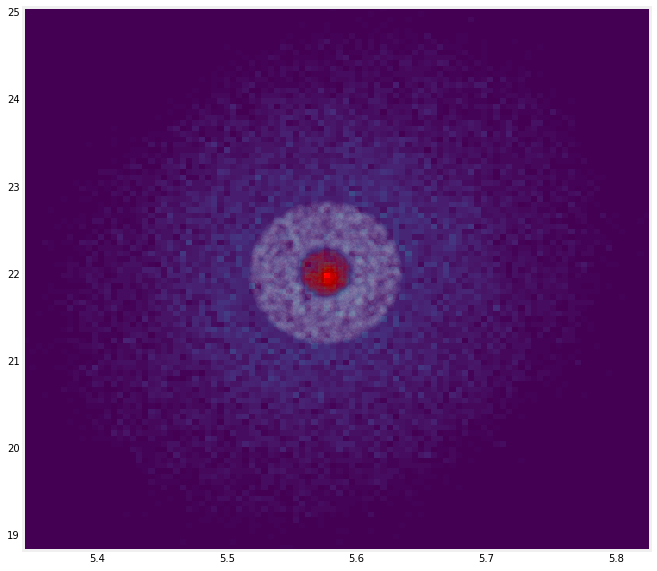

In [49]:
plt.figure(figsize=(10, 10))
plt.hist2d(ra, dec, bins=spatial_bins)
plt.scatter(ra[m_on], dec[m_on], alpha=0.02, color='red')
plt.scatter(ra[m_bkg], dec[m_bkg], alpha=0.02, color='white')
# plt.scatter(crab.ra.hourangle, crab.dec.deg)
plt.grid()

In [50]:
bins=np.logspace(-0.3, 1.2, 20, base=10)
bin_centers = np.sqrt(bins[0:-1] * bins[1:])
bin_widths = np.diff(bins)



# mc_energies = (mc_gammas.corsika_evt_header_total_energy.values * u.GeV).to('TeV').value
# mc_weights = crab_spectrum.event_weights(mc_energies, bins.min(), bins.max(), production_spectrum=mc_spectrum, t_obs=T_OBS.value, area=FACT_SCATTER_AREA.value)
# print(mc_weights)
# plt.hist(mc_energies, bins=bins, histtype='step', label='reweighted mc events', weights=mc_weights)
# plt.hist(signal, bins=bins, histtype='step', label='signal events')
# plt.hist(background, bins=bins, histtype='step', label='background events', weights=background_weights)
# plt.legend()
# plt.xscale('log')
# plt.yscale('log')
# None

PowerLaw Speltrum 
 Index:-2.0 
 Flux:0.09907178447074844


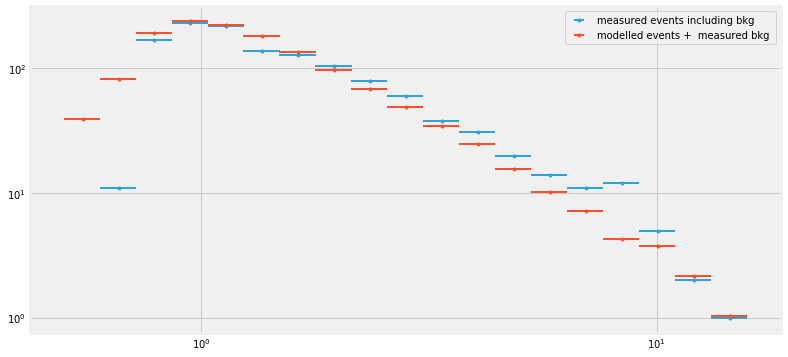

In [58]:
crab_spectrum = PowerLawSpectrum(index=INDEX_MAGIC, flux=N_MAGIC)

mc_production = {'production_index': -2.0, 'assumed_t_obs':T_OBS.value, 'e_max':E_MAX, 'e_min': E_MIN, 'total_showers_simulated' : 2000000, 'scatter_area' : FACT_SCATTER_AREA.value}
mc_spectrum = PowerLawSpectrum.from_mc_production(**mc_production)
print(mc_spectrum)
mc_weights = crab_spectrum.event_weights(mc_energies, E_MIN, E_MAX, production_spectrum=mc_spectrum, t_obs=T_OBS.value, area=FACT_SCATTER_AREA.value)


measured_counts_in_signal_region, _  = np.histogram(signal, bins=bins)
measured_bkg_counts, _  = np.histogram(background, bins=bins, weights=background_weights)
mc_gamma_counts, _  = np.histogram(mc_energies, bins=bins, weights=mc_weights)

expected_counts = mc_gamma_counts + measured_bkg_counts

plt.errorbar(bin_centers, measured_counts_in_signal_region,  xerr=bin_widths/2,  label='measured events including bkg', fmt='.')
# plt.errorbar(bin_centers, measured_bkg_counts,  xerr=bin_widths/2,  label='measured bkg ', fmt='.')
plt.errorbar(bin_centers, expected_counts,  xerr=bin_widths/2,  label='modelled events +  measured bkg ', fmt='.')
# plt.errorbar(bin_centers, mc_gamma_counts,  xerr=bin_widths/2,  label='modelled events', fmt='.')
plt.legend()
plt.xscale('log')
plt.yscale('log')

## Likelihood estimation

Binned poissonian Lieklihood.

In [52]:
def binned_poisson_likelihood(p, signal, background, mc, bins, area, T_OBS):
    '''
    Physical values have no astropy units attached here for speed.
    [T_OBS] = h
    [areas] = m^2
    [bins] = TeV
    '''
    N, index = p
    if N < 100 or N > 2000:
        return -np.inf
    if index < -4 or index > -1.0:
        return -np.inf 
    
    model = PowerLawSpectrum(index=index, flux=N * 1/(u.TeV * u.km**2 *u.h))
    
    
    measured_counts_in_signal_region, _  = np.histogram(signal, bins=bins)
    measured_bkg_counts, _  = np.histogram(background, bins=bins, weights=background_weights)
    
    mc_w = model.event_weights(mc, E_MIN, E_MAX, production_index=FACT_MC_INDEX,  t_obs=T_OBS.value, area=FACT_SCATTER_AREA.value, total_showers_simulated=N_TOTAL)
    
    mc_gamma_counts, _  = np.histogram(mc, bins=bins, weights=mc_w)
    M = mc_gamma_counts + measured_bkg_counts
    

    g = measured_counts_in_signal_region*np.log(M)
    
    g[g==np.inf] = 0

    return - (np.nansum(M) - np.nansum(g))

In [53]:
%timeit binned_poisson_likelihood((1000, i), signal, background, mc_energies, bins, area, T_OBS)

NameError: name 'i' is not defined

In [ ]:
x = np.linspace(-2, -3, 100)
binned_poisson = [binned_poisson_likelihood((1000, i), signal, background, mc_energies, bins, area, T_OBS) for i in x]

plt.plot(x, binned_poisson, label='poisson')
plt.legend()

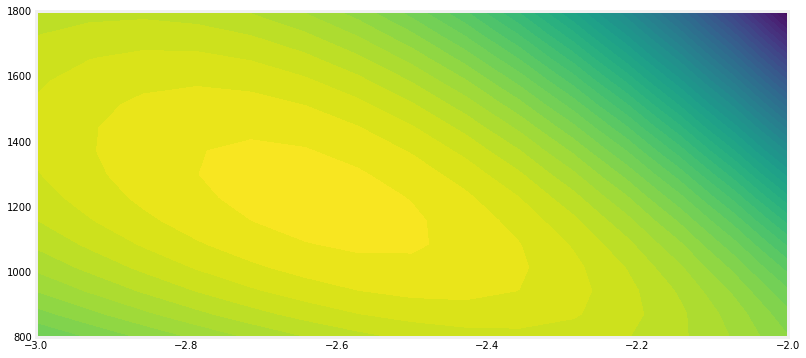

In [36]:
nx = 15
nn = 15

x = np.linspace(-2, -3, nx)
n = np.linspace(1800, 800, nn)

c = []
xv, yv = np.meshgrid(x, n, sparse=False, indexing='ij')
for i in range(nx):
    for j in range(nn):
        index, normal =  xv[i,j], yv[i,j]
        c.append(binned_poisson_likelihood((normal, index), signal, background, mc_energies, bins, area, T_OBS))

Z  = np.array(c).reshape(nx, nn)
plt.contourf(xv, yv, Z**(2), 50)

## MCMC

I use emcee to sample the likelihood landscape. One could certainly find a faster way. The uncertainties I get here are quite nice though. More complicated models are also not problematic when using this approach.

I start by initializing the walkers in a small ball around some educated guesses for the parameters.

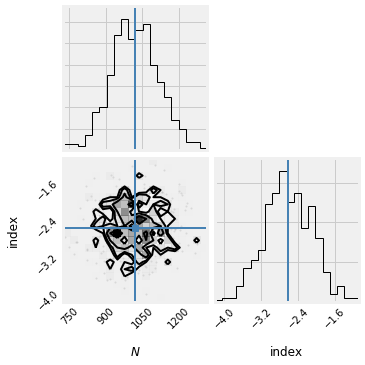

In [45]:
import corner
nwalkers = 500
ndim = 2 

range_n = [2000, 500]
range_index = [-2, -3]

p_a = np.random.normal(loc=N_HEGRA.value, scale=100, size=nwalkers) 
p_index = np.random.normal(loc=INDEX_HEGRA, scale=0.5,  size=nwalkers) 
p0 = np.vstack([p_a, p_index]).T

_ = corner.corner(p0, labels=['$N$', 'index'], truths=[N_HEGRA.value, INDEX_HEGRA])

In [46]:
import emcee

args  = [signal, background, mc_energies, bins, area, T_OBS]

sampler = emcee.EnsembleSampler(nwalkers, ndim, binned_poisson_likelihood, args=args, threads=4)
pos, prob, state = sampler.run_mcmc(p0, 50)
sampler.reset()
sampler.run_mcmc(pos, 300);
samples  = sampler.flatchain

/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


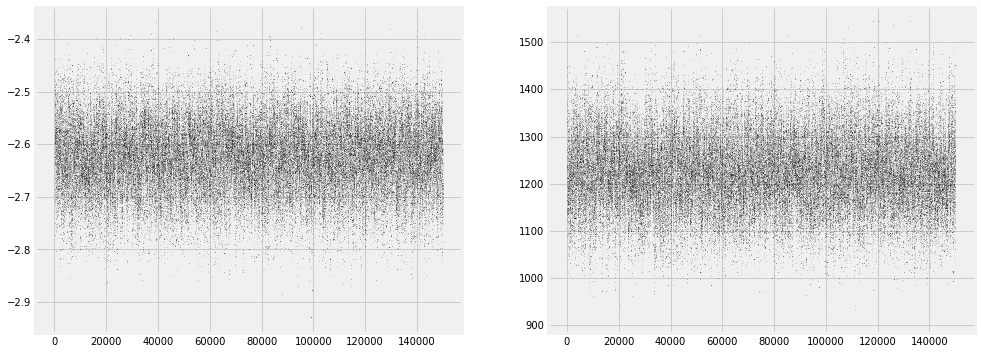

In [47]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(samples[:, 1], ',', color='k', alpha=0.1, )
ax2.plot(samples[:, 0], ',', color='k', alpha=0.1, )

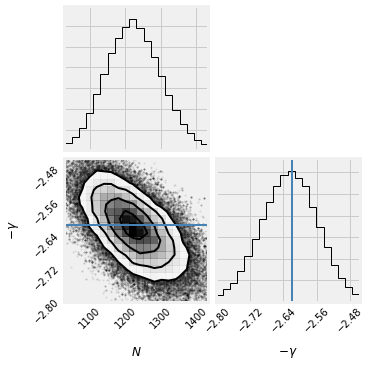

In [48]:
_ = corner.corner(samples,
                  labels=['$N$', '$-\gamma$'],
                  truths=[N_HEGRA.value, INDEX_HEGRA],
                  range=[0.99, 0.99]
                 )

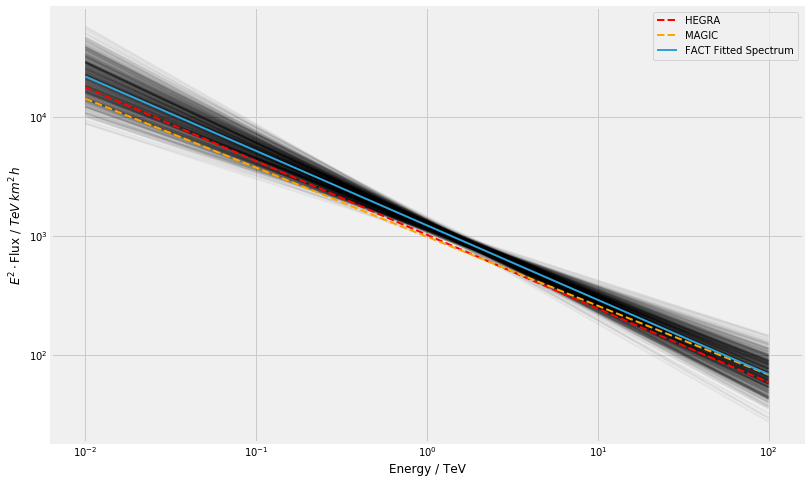

In [49]:
N_fit, index_fit = samples.mean(axis=0)

e = np.logspace(-2, 2, 50, base=10)
plt.figure(figsize=(12, 8))

for n, index in samples[np.random.randint(len(samples), size=500)]:
    plt.plot(e, e**2 * n * e **index, color='black', alpha=0.05)

h1, = plt.plot(e, e**2 * N_HEGRA * e **(INDEX_HEGRA) , '--', label='HEGRA ', color='red')
h2, = plt.plot(e, e**2 * N_MAGIC * e **(INDEX_MAGIC) , '--', label='MAGIC ', color='orange')
h3, = plt.plot(e, e**2 *  N_fit * e **(index_fit) , label='FACT Fitted Spectrum')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy / TeV')
plt.ylabel('$E^2 \cdot \mathrm{Flux}$ / $TeV\, km^2\, h$')
plt.legend()

In [50]:
n_mcmc, index_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

from IPython.display import display, Math, Latex
print('Index:')
display(Math('{{{:6.3f}}}_{{{:6.4f}}}^{{{:6.4f}}}$'.format(*index_mcmc)))

print('Normalization:')
display(Math('{{{:0.5f}}}_{{{:0.6f}}}^{{{:0.6f}}}$'.format(*n_mcmc)))


Index:


<IPython.core.display.Math object>

Normalization:


<IPython.core.display.Math object>